In [1]:
# Cell 1 – Setup and Imports

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d

# Set base project directory
base_dir = Path("../../ProjectsToIntegrate/sem_cd_analysis").resolve()

# Define data and result paths
data_path = base_dir / "data" / "raw" / "Measurements"
output_path = base_dir / "results"
plots_path = output_path / "plots"
tables_path = output_path / "tables"

# Create directories if they don't exist
for path in [output_path, plots_path, tables_path]:
    path.mkdir(parents=True, exist_ok=True)

# Verify paths
print(f"Base directory: {base_dir}")
print(f"Data path: {data_path}")
print(f"Output path: {output_path}")

# Plotting setup
plt.rcParams.update({
    "font.size": 12,
    "axes.grid": True,
    "grid.alpha": 0.4,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "figure.dpi": 120,
    "savefig.dpi": 300,
    "savefig.bbox": "tight"
})

print("\nSetup complete!")

Base directory: C:\Users\dreec\PycharmProjects\sem_cd_analysis
Data path: C:\Users\dreec\PycharmProjects\sem_cd_analysis\data\raw\Measurements
Output path: C:\Users\dreec\PycharmProjects\sem_cd_analysis\results

Setup complete!


Total rows loaded: 16
Categories found: ['Feature' 'Halo' 'Background']

Rows after excluding Halo: 13
Feature measurements: 12
Background measurements: 1
Doses measured: [np.int64(100), np.int64(250), np.int64(500), np.int64(1000), np.int64(1500), np.int64(2000), np.int64(3000), np.int64(5000), np.int64(7000), np.int64(10000), np.int64(15000), np.int64(20000)]

Background from ROIs: 131.87 ± nan

Peak intensity: 199.38 at 3000 µC/cm²

Normalized intensity range: -0.123 to 1.000
Number of negative values: 1

High dose normalized values:
  10000 µC/cm²: raw=158.8, norm=+0.3991
  15000 µC/cm²: raw=144.7, norm=+0.1908
  20000 µC/cm²: raw=123.6, norm=-0.1228


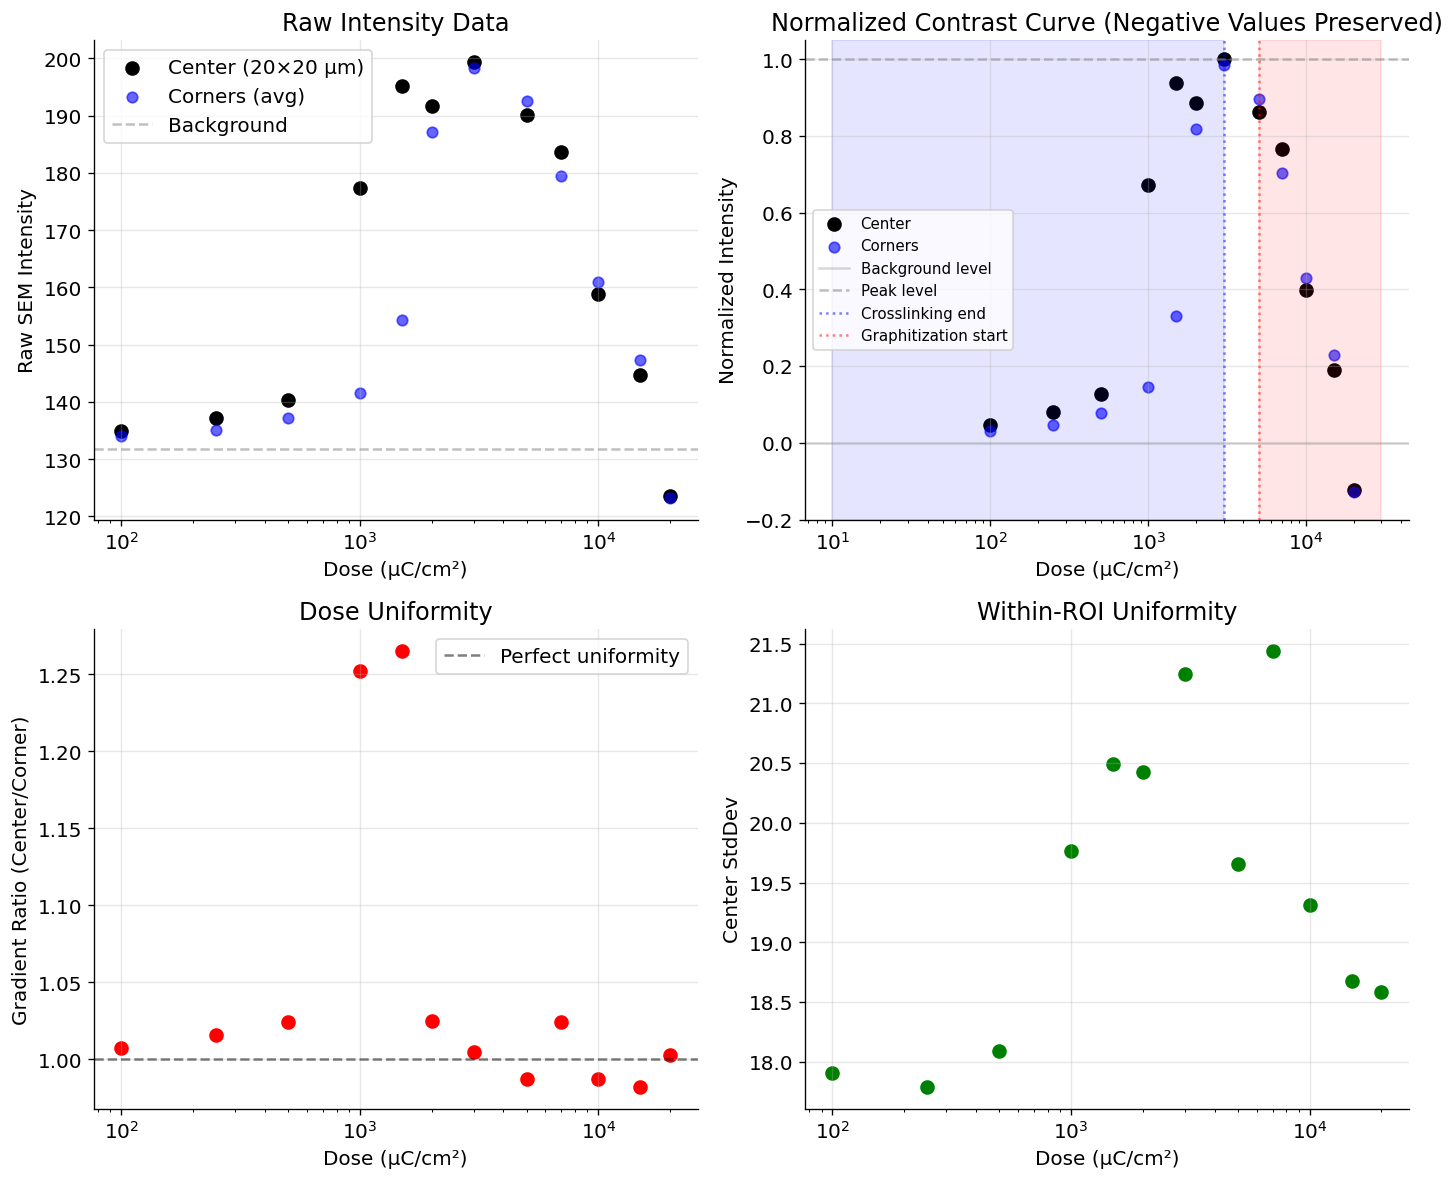


Contrast curve summary:
  Background intensity: 131.87
  Peak at 3000 µC/cm² with intensity 199.38
  Dynamic range: 1.5x

Normalized intensities at key doses:
    100 µC/cm²: +0.0464
    250 µC/cm²: +0.0797
    500 µC/cm²: +0.1262
   1000 µC/cm²: +0.6735
   2000 µC/cm²: +0.8870
   3000 µC/cm²: +1.0000
   5000 µC/cm²: +0.8621
  10000 µC/cm²: +0.3991
  20000 µC/cm²: -0.1228


In [11]:
# Cell 2 - Load and Preprocess Data with Center ROI Measurements

# Load all measurements
df_all = pd.read_csv(data_path / "sem_intensity_measurements.csv")
print(f"Total rows loaded: {len(df_all)}")
print(f"Categories found: {df_all['Category'].unique()}")

# Filter for only Feature and Background (exclude Halo)
df_contrast = df_all[df_all["Category"].isin(["Feature", "Background"])].copy()
print(f"\nRows after excluding Halo: {len(df_contrast)}")

# Separate features and backgrounds
df_features = df_contrast[df_contrast["Category"] == "Feature"].copy()
df_background = df_contrast[df_contrast["Category"] == "Background"].copy()

print(f"Feature measurements: {len(df_features)}")
print(f"Background measurements: {len(df_background)}")
print(f"Doses measured: {sorted(df_features['Dose_uC_cm2'].unique())}")

# Calculate background from background ROIs or low doses
if len(df_background) > 0:
    background_intensity = df_background["Center_Mean"].mean()
    background_std = df_background["Center_Mean"].std()
    print(f"\nBackground from ROIs: {background_intensity:.2f} ± {background_std:.2f}")
else:
    # Use average of 100 and 250 µC/cm² as background estimate
    low_dose_mask = df_features["Dose_uC_cm2"].isin([100, 250])
    background_intensity = df_features.loc[low_dose_mask, "Center_Mean"].mean()
    print(f"Background from low doses: {background_intensity:.2f}")

# Sort by dose for proper plotting
df_features = df_features.sort_values('Dose_uC_cm2')

# Extract center intensities (20% x 20% ROI measurements)
doses = df_features["Dose_uC_cm2"].values
center_intensities = df_features["Center_Mean"].values

# Find peak intensity (before graphitization)
max_intensity = np.max(center_intensities)
max_dose = doses[np.argmax(center_intensities)]
print(f"\nPeak intensity: {max_intensity:.2f} at {max_dose} µC/cm²")

# Normalize: 0 = background, 1 = peak signal
norm_intensities = (center_intensities - background_intensity) / (max_intensity - background_intensity)
# REMOVED CLIPPING - Allow negative values for sub-background intensities
# norm_intensities = np.clip(norm_intensities, 0, 1)  # Ensure 0-1 range

# Print normalization range
print(f"\nNormalized intensity range: {norm_intensities.min():.3f} to {norm_intensities.max():.3f}")
print(f"Number of negative values: {np.sum(norm_intensities < 0)}")

# Check high dose values
high_dose_mask = doses >= 10000
if np.any(high_dose_mask):
    print(f"\nHigh dose normalized values:")
    for d, raw, norm in zip(doses[high_dose_mask], 
                           center_intensities[high_dose_mask], 
                           norm_intensities[high_dose_mask]):
        print(f"  {d:5.0f} µC/cm²: raw={raw:.1f}, norm={norm:+.4f}")

# Create processed dataframe
df_processed = df_features.copy()
df_processed["Norm_Intensity"] = norm_intensities
df_processed["Log_Dose"] = np.log10(doses)

# Calculate corner statistics
corner_cols = ["Corner_TL", "Corner_TR", "Corner_BL", "Corner_BR"]
df_processed["Corner_Mean"] = df_processed[corner_cols].mean(axis=1)
df_processed["Corner_Std"] = df_processed[corner_cols].std(axis=1)
df_processed["Norm_Corner"] = (df_processed["Corner_Mean"] - background_intensity) / (max_intensity - background_intensity)

# Save processed data
processed_path = base_dir / "data" / "processed"
processed_path.mkdir(parents=True, exist_ok=True)
df_processed.to_csv(processed_path / "contrast_data_processed.csv", index=False)

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot 1: Raw intensities
ax = axes[0, 0]
ax.scatter(doses, center_intensities, color='black', s=60, label='Center (20×20 µm)')
ax.scatter(doses, df_processed["Corner_Mean"], color='blue', s=40, alpha=0.6, label='Corners (avg)')
ax.axhline(background_intensity, color='gray', linestyle='--', alpha=0.5, label='Background')
ax.set_xscale('log')
ax.set_xlabel('Dose (µC/cm²)')
ax.set_ylabel('Raw SEM Intensity')
ax.set_title('Raw Intensity Data')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 2: Normalized contrast curve
ax = axes[0, 1]
ax.scatter(doses, norm_intensities, color='black', s=60, label='Center')
ax.scatter(doses, df_processed["Norm_Corner"], color='blue', s=40, alpha=0.6, label='Corners')
ax.axhline(0, color='gray', linestyle='-', alpha=0.3, label='Background level')
ax.axhline(1.0, color='gray', linestyle='--', alpha=0.5, label='Peak level')
ax.axvline(3000, color='blue', linestyle=':', alpha=0.5, label='Crosslinking end')
ax.axvline(5000, color='red', linestyle=':', alpha=0.5, label='Graphitization start')
ax.axvspan(10, 3000, alpha=0.1, color='blue')
ax.axvspan(5000, 30000, alpha=0.1, color='red')
ax.set_xscale('log')
ax.set_xlabel('Dose (µC/cm²)')
ax.set_ylabel('Normalized Intensity')
ax.set_title('Normalized Contrast Curve (Negative Values Preserved)')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)
# Adjust y-limits to show negative values
ax.set_ylim(min(-0.2, norm_intensities.min() - 0.05), 1.05)

# Plot 3: Gradient ratio
ax = axes[1, 0]
ax.scatter(doses, df_processed["Gradient_Ratio"], color='red', s=60)
ax.axhline(1.0, color='black', linestyle='--', alpha=0.5, label='Perfect uniformity')
ax.set_xscale('log')
ax.set_xlabel('Dose (µC/cm²)')
ax.set_ylabel('Gradient Ratio (Center/Corner)')
ax.set_title('Dose Uniformity')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 4: Center standard deviation
ax = axes[1, 1]
ax.scatter(doses, df_processed["Center_StdDev"], color='green', s=60)
ax.set_xscale('log')
ax.set_xlabel('Dose (µC/cm²)')
ax.set_ylabel('Center StdDev')
ax.set_title('Within-ROI Uniformity')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(plots_path / "contrast_data_overview.png", dpi=300)
plt.show()

# Print summary statistics
print(f"\nContrast curve summary:")
print(f"  Background intensity: {background_intensity:.2f}")
print(f"  Peak at {max_dose} µC/cm² with intensity {max_intensity:.2f}")
print(f"  Dynamic range: {max_intensity/background_intensity:.1f}x")
print(f"\nNormalized intensities at key doses:")
for d in [100, 250, 500, 1000, 2000, 3000, 5000, 10000, 20000]:
    if d in doses:
        idx = list(doses).index(d)
        print(f"  {d:5d} µC/cm²: {norm_intensities[idx]:+.4f}")


=== NORMALIZATION CHECK ===
Min normalized intensity: -0.123
Max normalized intensity: 1.000
Number of negative values: 1
Number of values exactly = 0: 0

High dose values (≥10000 µC/cm²):
  Dose  10000 µC/cm² -> Normalized intensity: +0.3991
  Dose  15000 µC/cm² -> Normalized intensity: +0.1908
  Dose  20000 µC/cm² -> Normalized intensity: -0.1228
=== LOW DOSE DATA CHECK ===
Number of low dose points: 7
Low dose range: 100 - 3000 µC/cm²
Intensity range: 0.046 - 1.000

=== CROSSLINKING FIT (Sigmoid) ===
D₁₀: 453.1 µC/cm²
D₅₀: 807.0 µC/cm²
D₉₀: 1437.5 µC/cm²
γ (Contrast): 2.19
Amplitude: 0.980
R²: 0.9882

=== HIGH DOSE DATA CHECK ===
Number of high dose points: 5
High dose range: 5000 - 20000 µC/cm²
Intensity range: -0.123 - 0.862

Actual high dose data:
  Dose   5000 µC/cm² -> Intensity +0.8621
  Dose   7000 µC/cm² -> Intensity +0.7669
  Dose  10000 µC/cm² -> Intensity +0.3991
  Dose  15000 µC/cm² -> Intensity +0.1908
  Dose  20000 µC/cm² -> Intensity -0.1228

Note: 1 negative intensi

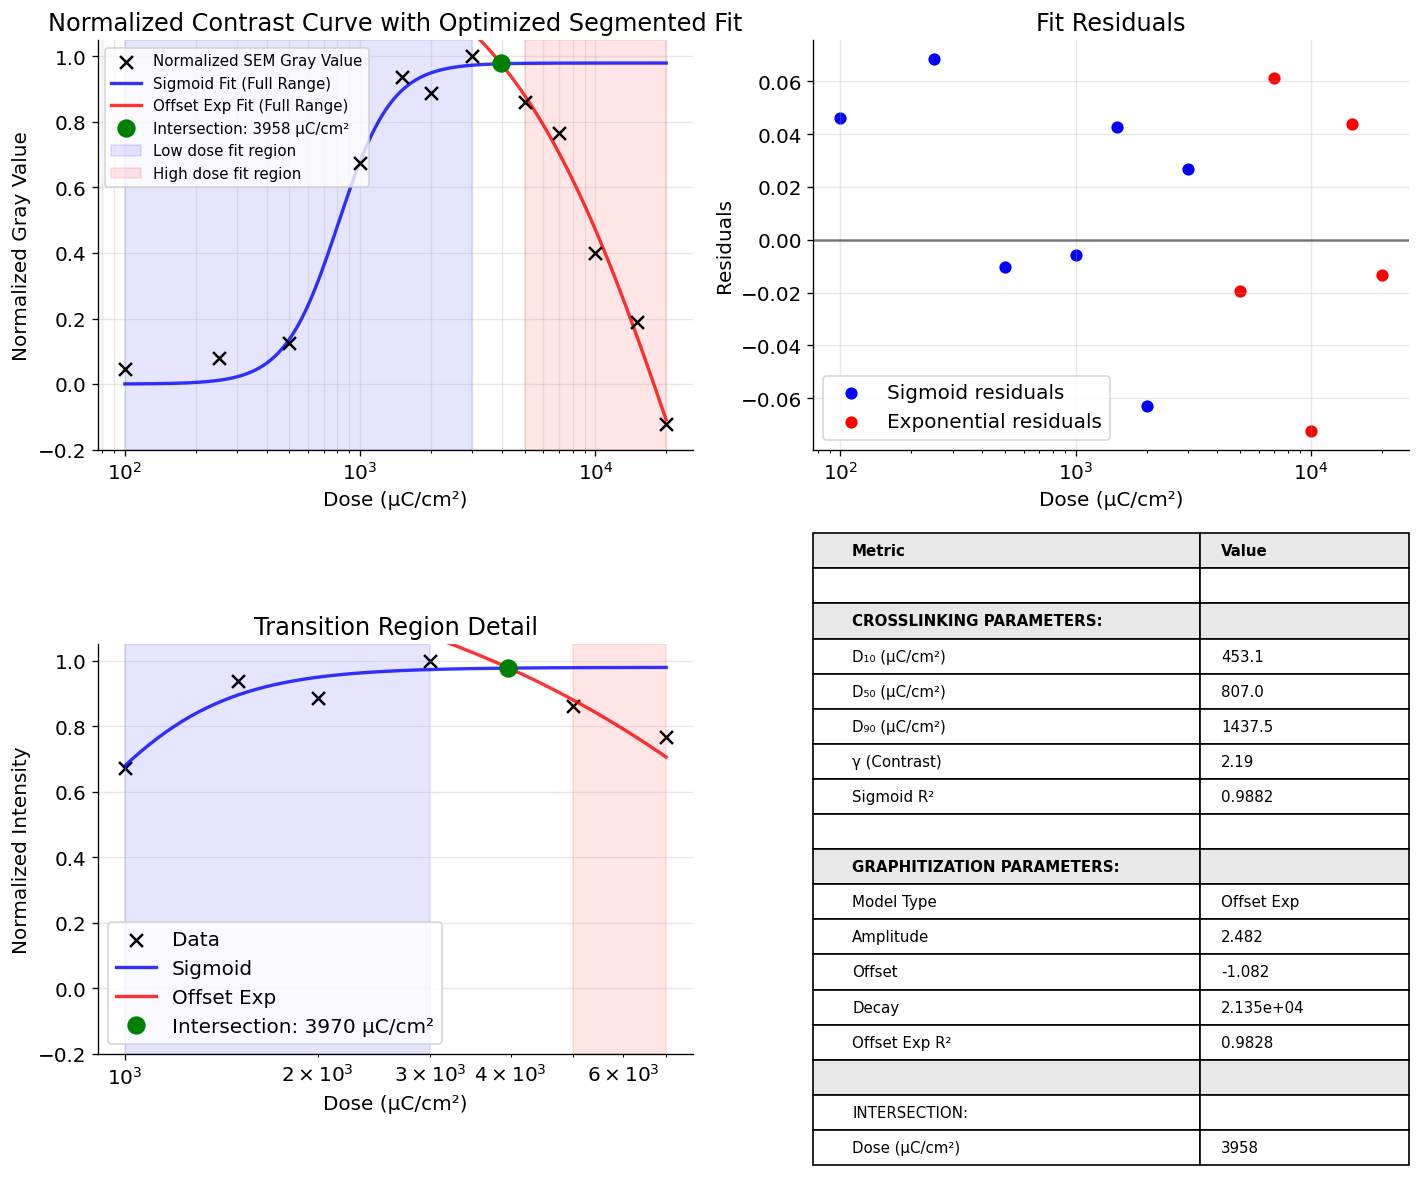


=== SIGMOID FIT REPORT ===
[[Model]]
    Model(step, form='logistic')
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 41
    # data points      = 7
    # variables        = 3
    chi-square         = 0.01344162
    reduced chi-square = 0.00336040
    Akaike info crit   = -37.7871678
    Bayesian info crit = -37.9494374
    R-squared          = 0.98815394
[[Variables]]
    amplitude:  0.97982438 +/- 0.04757432 (4.86%) (init = 1)
    center:     2.90688509 +/- 0.03220946 (1.11%) (init = 3)
    sigma:      0.11411504 +/- 0.02401835 (21.05%) (init = 0.3)
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma)  = +0.5581
    C(amplitude, center) = +0.5243

=== EXPONENTIAL FIT REPORT ===
[[Model]]
    Model(offset_exp)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 5
    # variables        = 3
    chi-square         = 0.01142582
    reduced chi-square = 0.00571291
    Akaike info cr

In [12]:
# Cell 3 - Using lmfit (matching reference script approach)
# NOTE: Run the fixed Cell 2 first to ensure negative values are preserved!

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lmfit import Model
from lmfit.models import StepModel, ExponentialModel, LinearModel, PowerLawModel, PolynomialModel

# Load processed data
df = pd.read_csv(processed_path / "contrast_data_processed.csv")
doses = df["Dose_uC_cm2"].values
norm_intensity = df["Norm_Intensity"].values
log_doses = np.log10(doses)

# Debug normalization
print("\n=== NORMALIZATION CHECK ===")
print(f"Min normalized intensity: {norm_intensity.min():.3f}")
print(f"Max normalized intensity: {norm_intensity.max():.3f}")
print(f"Number of negative values: {np.sum(norm_intensity < 0)}")
print(f"Number of values exactly = 0: {np.sum(norm_intensity == 0)}")

# Check high dose values specifically
high_dose_indices = doses >= 10000
if np.any(high_dose_indices):
    print(f"\nHigh dose values (≥10000 µC/cm²):")
    for d, i in zip(doses[high_dose_indices], norm_intensity[high_dose_indices]):
        print(f"  Dose {d:6.0f} µC/cm² -> Normalized intensity: {i:+.4f}")
else:
    print("\nNo doses ≥10000 µC/cm² found")

# Check if we have proper negative values
if norm_intensity.min() >= 0:
    print("\nWARNING: No negative values found! Data may be clipped.")
    print("Check if preprocessing is using np.clip() to force [0,1] range.")

# === SEGMENTED FITTING APPROACH ===
# Segment data
low_dose_mask = doses <= 3000
high_dose_mask = doses >= 5000

# === CROSSLINKING REGION - Sigmoidal fit to low dose region ===
# Debug: Check the low dose data
print("=== LOW DOSE DATA CHECK ===")
print(f"Number of low dose points: {np.sum(low_dose_mask)}")
print(f"Low dose range: {doses[low_dose_mask].min():.0f} - {doses[low_dose_mask].max():.0f} µC/cm²")
print(f"Intensity range: {norm_intensity[low_dose_mask].min():.3f} - {norm_intensity[low_dose_mask].max():.3f}")

sigmoid = StepModel(form='logistic')

# Make parameters with baseline
params_low = sigmoid.make_params()

# Set center to where intensity is around 0.5
intensity_low = norm_intensity[low_dose_mask]
log_doses_low = log_doses[low_dose_mask]
half_max_idx = np.argmin(np.abs(intensity_low - 0.5))
center_guess = log_doses_low[half_max_idx] if len(log_doses_low) > 0 else np.median(log_doses_low)

# Set parameters to ensure proper sigmoid that goes from 0 to 1
params_low['center'].set(value=center_guess, min=1.5, max=3.5)
params_low['sigma'].set(value=0.3, min=0.05, max=1.0)
params_low['amplitude'].set(value=1.0, min=0.8, max=1.2)  # Allow some flexibility around 1

# If the model has a baseline parameter, set it to 0
if 'baseline' in params_low:
    params_low['baseline'].set(value=0, vary=False)  # Fix baseline at 0

try:
    result_low = sigmoid.fit(intensity_low, 
                            x=log_doses_low, 
                            params=params_low)
    
    # Extract metrics from sigmoid
    D50 = 10**result_low.params["center"].value
    gamma = 1 / (4 * result_low.params["sigma"].value)
    D10 = 10 ** (result_low.params["center"].value - 2.197 * result_low.params["sigma"].value)
    D90 = 10 ** (result_low.params["center"].value + 2.197 * result_low.params["sigma"].value)
    
    print(f"\n=== CROSSLINKING FIT (Sigmoid) ===")
    print(f"D₁₀: {D10:.1f} µC/cm²")
    print(f"D₅₀: {D50:.1f} µC/cm²")
    print(f"D₉₀: {D90:.1f} µC/cm²")
    print(f"γ (Contrast): {gamma:.2f}")
    print(f"Amplitude: {result_low.params['amplitude'].value:.3f}")
    if 'baseline' in result_low.params:
        print(f"Baseline: {result_low.params['baseline'].value:.3f}")
    print(f"R²: {result_low.rsquared:.4f}")
    
except Exception as e:
    print(f"Sigmoid fitting error: {e}")
    result_low = None

# === GRAPHITIZATION REGION - Find best fit for high dose region ===
# Debug: Check the high dose data
print(f"\n=== HIGH DOSE DATA CHECK ===")
print(f"Number of high dose points: {np.sum(high_dose_mask)}")
print(f"High dose range: {doses[high_dose_mask].min():.0f} - {doses[high_dose_mask].max():.0f} µC/cm²")
print(f"Intensity range: {norm_intensity[high_dose_mask].min():.3f} - {norm_intensity[high_dose_mask].max():.3f}")

# Print actual data to verify trend
print("\nActual high dose data:")
for d, i in zip(doses[high_dose_mask], norm_intensity[high_dose_mask]):
    print(f"  Dose {d:6.0f} µC/cm² -> Intensity {i:+.4f}")

# Try multiple models and find the best one
high_doses = doses[high_dose_mask]
high_intensities = norm_intensity[high_dose_mask]
high_log_doses = log_doses[high_dose_mask]

# Note about negative values in high dose region
if np.any(high_intensities < 0):
    print(f"\nNote: {np.sum(high_intensities < 0)} negative intensity values found in high dose region.")
    print("Some models (power law, log-linear) may have issues with negative values.")

best_model = None
best_result = None
best_r2 = -999
best_model_name = "None"

print("\n=== TRYING DIFFERENT MODELS FOR HIGH DOSE REGION ===")

# 1. Power Law Model: I = A * dose^k
try:
    power_model = PowerLawModel()
    params = power_model.make_params()
    params['amplitude'].set(value=1e3, min=1e-6, max=1e6)
    params['exponent'].set(value=-1, min=-5, max=-0.01)
    result = power_model.fit(high_intensities, x=high_doses, params=params)
    print(f"\n1. Power Law Model (I = A * dose^k):")
    print(f"   R² = {result.rsquared:.4f}")
    if result.rsquared > best_r2:
        best_model = power_model
        best_result = result
        best_r2 = result.rsquared
        best_model_name = "Power Law"
except Exception as e:
    print(f"   Power law failed: {e}")

# 2. Linear in log-log space
try:
    # Can only use positive intensities for log-log
    positive_mask = high_intensities > 0
    if np.sum(positive_mask) > 2:
        log_intensity = np.log10(high_intensities[positive_mask])
        log_dose_filtered = high_log_doses[positive_mask]
        linear_model = LinearModel()
        params = linear_model.make_params(slope=-1, intercept=0)
        result = linear_model.fit(log_intensity, x=log_dose_filtered, params=params)
        print(f"\n2. Linear in log-log space (using {np.sum(positive_mask)} positive points):")
        print(f"   R² = {result.rsquared:.4f}")
        if result.rsquared > best_r2:
            # Create a custom model for plotting
            def log_linear(x, slope, intercept):
                return 10**(slope * np.log10(x) + intercept)
            best_model = Model(log_linear)
            best_result = result
            best_r2 = result.rsquared
            best_model_name = "Log-Linear"
    else:
        print(f"\n2. Linear in log-log space: Skipped (only {np.sum(positive_mask)} positive points)")
except Exception as e:
    print(f"   Log-linear failed: {e}")

# 3. Simple linear in log dose vs intensity
try:
    linear_model = LinearModel()
    params = linear_model.make_params(slope=-0.1, intercept=0.5)
    result = linear_model.fit(high_intensities, x=high_log_doses, params=params)
    print(f"\n3. Linear (intensity vs log dose):")
    print(f"   R² = {result.rsquared:.4f}")
    if result.rsquared > best_r2:
        best_model = linear_model
        best_result = result
        best_r2 = result.rsquared
        best_model_name = "Linear"
except Exception as e:
    print(f"   Linear failed: {e}")

# 4. Inverse Model: I = A / (dose + B)
try:
    def inverse_model(x, amplitude, offset):
        return amplitude / (x + offset)
    
    inv_model = Model(inverse_model)
    params = inv_model.make_params(amplitude=1000, offset=1000)
    params['amplitude'].set(min=1, max=1e6)
    params['offset'].set(min=0, max=1e5)
    result = inv_model.fit(high_intensities, x=high_doses, params=params)
    print(f"\n4. Inverse Model (I = A / (dose + B)):")
    print(f"   R² = {result.rsquared:.4f}")
    if result.rsquared > best_r2:
        best_model = inv_model
        best_result = result
        best_r2 = result.rsquared
        best_model_name = "Inverse"
except Exception as e:
    print(f"   Inverse model failed: {e}")

# 5. Polynomial in log space (2nd order)
try:
    poly_model = PolynomialModel(degree=2)
    params = poly_model.make_params()
    result = poly_model.fit(high_intensities, x=high_log_doses, params=params)
    print(f"\n5. Polynomial (2nd order) in log space:")
    print(f"   R² = {result.rsquared:.4f}")
    if result.rsquared > best_r2:
        best_model = poly_model
        best_result = result
        best_r2 = result.rsquared
        best_model_name = "Polynomial"
except Exception as e:
    print(f"   Polynomial failed: {e}")

# 6. Custom stretched exponential
try:
    def stretched_exp(x, amplitude, tau, beta):
        return amplitude * np.exp(-((x/tau)**beta))
    
    stretch_model = Model(stretched_exp)
    params = stretch_model.make_params(amplitude=0.5, tau=10000, beta=0.5)
    params['amplitude'].set(min=0.01, max=2)
    params['tau'].set(min=1000, max=50000)
    params['beta'].set(min=0.1, max=2)
    result = stretch_model.fit(high_intensities, x=high_doses, params=params)
    print(f"\n6. Stretched Exponential:")
    print(f"   R² = {result.rsquared:.4f}")
    if result.rsquared > best_r2:
        best_model = stretch_model
        best_result = result
        best_r2 = result.rsquared
        best_model_name = "Stretched Exp"
except Exception as e:
    print(f"   Stretched exponential failed: {e}")

# 7. Offset exponential for negative values
try:
    def offset_exp(x, amplitude, offset, decay):
        """Exponential with offset to handle negative values: I = A * exp(-x/decay) + offset"""
        return amplitude * np.exp(-x/decay) + offset
    
    offset_model = Model(offset_exp)
    # Estimate offset as the minimum intensity
    offset_est = high_intensities.min()
    params = offset_model.make_params(
        amplitude=high_intensities[0] - offset_est, 
        offset=offset_est,
        decay=5000
    )
    params['decay'].set(min=100, max=50000)
    result = offset_model.fit(high_intensities, x=high_doses, params=params)
    print(f"\n7. Offset Exponential (for negative values):")
    print(f"   R² = {result.rsquared:.4f}")
    if result.rsquared > best_r2:
        best_model = offset_model
        best_result = result
        best_r2 = result.rsquared
        best_model_name = "Offset Exp"
except Exception as e:
    print(f"   Offset exponential failed: {e}")

# 8. Linear with offset (simplest model for data with negative values)
try:
    def linear_offset(x, slope, intercept):
        """Simple linear model: I = slope * x + intercept"""
        return slope * x + intercept
    
    lin_offset_model = Model(linear_offset)
    params = lin_offset_model.make_params(
        slope=(high_intensities[-1] - high_intensities[0]) / (high_doses[-1] - high_doses[0]),
        intercept=high_intensities[0]
    )
    result = lin_offset_model.fit(high_intensities, x=high_doses, params=params)
    print(f"\n8. Linear with offset (dose space):")
    print(f"   R² = {result.rsquared:.4f}")
    if result.rsquared > best_r2:
        best_model = lin_offset_model
        best_result = result
        best_r2 = result.rsquared
        best_model_name = "Linear Offset"
except Exception as e:
    print(f"   Linear offset failed: {e}")

# Use the best model
if best_result is not None:
    print(f"\n=== BEST FIT: {best_model_name} (R² = {best_r2:.4f}) ===")
    print("Parameters:")
    for param_name in best_result.params:
        print(f"  {param_name}: {best_result.params[param_name].value:.3e}")
    
    result_high = best_result
    expo = best_model  # Keep the name for compatibility
    
    # Verify the fit
    if best_model_name == "Power Law":
        test_doses = np.array([5000, 10000, 20000])
        test_intensities = best_model.eval(best_result.params, x=test_doses)
    elif best_model_name == "Log-Linear":
        test_doses = np.array([5000, 10000, 20000])
        test_log_doses = np.log10(test_doses)
        # Recreate intensities from log-log fit
        slope = best_result.params['slope'].value
        intercept = best_result.params['intercept'].value
        test_intensities = 10**(slope * test_log_doses + intercept)
    elif best_model_name == "Linear":
        test_doses = np.array([5000, 10000, 20000])
        test_log_doses = np.log10(test_doses)
        test_intensities = best_model.eval(best_result.params, x=test_log_doses)
    elif best_model_name == "Polynomial":
        test_doses = np.array([5000, 10000, 20000])
        test_log_doses = np.log10(test_doses)
        test_intensities = best_model.eval(best_result.params, x=test_log_doses)
    else:
        test_doses = np.array([5000, 10000, 20000])
        test_intensities = best_model.eval(best_result.params, x=test_doses)
    
    print(f"\nFit check at key doses:")
    for d, i in zip(test_doses, test_intensities):
        print(f"  Dose {d:5.0f} µC/cm² -> Intensity {i:+.4f}")
else:
    print("\nERROR: No model successfully fit the high dose data!")
    result_high = None
    expo = None  # Define expo even if fitting fails

# === PREPARE CURVES FOR PLOTTING ===
x_fit = np.linspace(log_doses.min(), log_doses.max(), 400)
x_fit_doses = 10**x_fit
low_fit = sigmoid.eval(result_low.params, x=x_fit) if result_low else None

# Initialize variables for safety
if 'best_model_name' not in locals():
    best_model_name = "None"
if 'best_model' not in locals():
    best_model = None

# For high fit, evaluate based on the best model type
if result_high is not None and best_model_name != "None":
    if best_model_name == "Power Law":
        high_fit = best_model.eval(result_high.params, x=x_fit_doses)
    elif best_model_name == "Log-Linear":
        # Recreate from log-log linear fit
        slope = result_high.params['slope'].value
        intercept = result_high.params['intercept'].value
        high_fit = 10**(slope * x_fit + intercept)
    elif best_model_name == "Linear":
        high_fit = best_model.eval(result_high.params, x=x_fit)
    elif best_model_name == "Polynomial":
        high_fit = best_model.eval(result_high.params, x=x_fit)
    elif best_model_name in ["Inverse", "Stretched Exp", "Offset Exp", "Linear Offset"]:
        high_fit = best_model.eval(result_high.params, x=x_fit_doses)
    else:
        high_fit = best_model.eval(result_high.params, x=x_fit)
else:
    high_fit = None

# Check the actual range of the fitted curves
if low_fit is not None:
    print(f"\nSigmoid fit range: {low_fit.min():.3f} to {low_fit.max():.3f}")
if high_fit is not None:
    print(f"{best_model_name} fit range: {high_fit.min():.3f} to {high_fit.max():.3f}")

# === COMPREHENSIVE PLOTTING ===
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot 1: Full contrast curve
ax = axes[0, 0]
ax.scatter(doses, norm_intensity, color='black', s=60, zorder=10, 
          marker='x', label='Normalized SEM Gray Value')

# Plot both fits over the full range
if low_fit is not None:
    ax.plot(10**x_fit, low_fit, 'b-', linewidth=2, alpha=0.8,
            label='Sigmoid Fit (Full Range)')

if high_fit is not None and 'best_model_name' in locals():
    ax.plot(10**x_fit, high_fit, 'r-', linewidth=2, alpha=0.8,
            label=f'{best_model_name} Fit (Full Range)')

# Find and mark intersection point
if low_fit is not None and high_fit is not None:
    diff = np.abs(low_fit - high_fit)
    intersect_idx = np.argmin(diff)
    intersect_dose = 10**x_fit[intersect_idx]
    intersect_intensity = (low_fit[intersect_idx] + high_fit[intersect_idx]) / 2
    
    ax.plot(intersect_dose, intersect_intensity, 'go', markersize=10, zorder=15,
            label=f'Intersection: {intersect_dose:.0f} µC/cm²')

# Add visual indicators for fitting regions
ax.axvspan(doses.min(), 3000, alpha=0.1, color='blue', label='Low dose fit region')
ax.axvspan(5000, doses.max(), alpha=0.1, color='red', label='High dose fit region')

ax.set_xscale('log')
ax.set_xlabel('Dose (µC/cm²)')
ax.set_ylabel('Normalized Gray Value')
ax.set_title('Normalized Contrast Curve with Optimized Segmented Fit')
ax.legend(loc='best', fontsize=9)
ax.grid(True, alpha=0.3, which='both')
ax.set_ylim(min(-0.2, norm_intensity.min() - 0.05), 1.05)

# Plot 2: Fit quality check
ax = axes[0, 1]
if result_low is not None:
    ax.scatter(doses[low_dose_mask], result_low.residual, color='blue', s=40, 
              label='Sigmoid residuals')
if result_high is not None:
    ax.scatter(doses[high_dose_mask], result_high.residual, color='red', s=40,
              label='Exponential residuals')
ax.axhline(0, color='black', linestyle='-', alpha=0.5)
ax.set_xscale('log')
ax.set_xlabel('Dose (µC/cm²)')
ax.set_ylabel('Residuals')
ax.set_title('Fit Residuals')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 3: Transition region detail
ax = axes[1, 0]
trans_mask = (doses >= 1000) & (doses <= 7000)
ax.scatter(doses[trans_mask], norm_intensity[trans_mask], 
          color='black', s=60, marker='x', label='Data')

# Show extrapolated fits in transition region
if low_fit is not None and high_fit is not None and result_high is not None and 'best_model_name' in locals():
    x_trans = np.linspace(np.log10(1000), np.log10(7000), 200)
    x_trans_doses = 10**x_trans
    y_low_trans = sigmoid.eval(result_low.params, x=x_trans)
    
    # Evaluate high dose model in transition region
    if best_model_name == "Power Law":
        y_high_trans = best_model.eval(result_high.params, x=x_trans_doses)
    elif best_model_name == "Log-Linear":
        slope = result_high.params['slope'].value
        intercept = result_high.params['intercept'].value
        y_high_trans = 10**(slope * x_trans + intercept)
    elif best_model_name == "Linear":
        y_high_trans = best_model.eval(result_high.params, x=x_trans)
    elif best_model_name == "Polynomial":
        y_high_trans = best_model.eval(result_high.params, x=x_trans)
    elif best_model_name in ["Inverse", "Stretched Exp", "Offset Exp", "Linear Offset"]:
        y_high_trans = best_model.eval(result_high.params, x=x_trans_doses)
    else:
        y_high_trans = best_model.eval(result_high.params, x=x_trans) if best_model else None
    
    if y_high_trans is not None:
        ax.plot(10**x_trans, y_low_trans, 'b-', linewidth=2, alpha=0.8,
                label='Sigmoid')
        ax.plot(10**x_trans, y_high_trans, 'r-', linewidth=2, alpha=0.8,
                label=best_model_name)
        
        # Find crossover point in transition region
        diff = np.abs(y_low_trans - y_high_trans)
        crossover_idx = np.argmin(diff)
        crossover_dose = 10**x_trans[crossover_idx]
        crossover_intensity = (y_low_trans[crossover_idx] + y_high_trans[crossover_idx]) / 2
        
        ax.plot(crossover_dose, crossover_intensity, 'go', markersize=10, 
                label=f'Intersection: {crossover_dose:.0f} µC/cm²')
    
    # Add shaded regions to show fit zones
    ax.axvspan(1000, 3000, alpha=0.1, color='blue')
    ax.axvspan(5000, 7000, alpha=0.1, color='red')

ax.set_xscale('log')
ax.set_xlabel('Dose (µC/cm²)')
ax.set_ylabel('Normalized Intensity')
ax.set_title('Transition Region Detail')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_ylim(min(-0.2, norm_intensity[trans_mask].min() - 0.05) if np.any(trans_mask) else -0.2, 1.05)

# Plot 4: Metrics table
ax = axes[1, 1]
ax.axis('off')

# Create metrics table
if result_low is not None and result_high is not None and 'best_model_name' in locals():
    # Calculate intersection dose for the table
    diff_full = np.abs(low_fit - high_fit)
    intersect_idx_full = np.argmin(diff_full)
    intersect_dose_full = 10**x_fit[intersect_idx_full]
    
    # Build parameter rows based on the best model
    param_rows = []
    param_rows.append(["Model Type", best_model_name])
    
    # Add all parameters from the best fit
    for param_name in result_high.params:
        value = result_high.params[param_name].value
        if abs(value) < 0.01 or abs(value) > 1000:
            param_rows.append([param_name.capitalize(), f"{value:.3e}"])
        else:
            param_rows.append([param_name.capitalize(), f"{value:.3f}"])
    
    param_rows.append([f"{best_model_name} R²", f"{result_high.rsquared:.4f}"])
    
    metrics_data = [
        ["Metric", "Value"],
        ["", ""],
        ["CROSSLINKING PARAMETERS:", ""],
        ["D₁₀ (µC/cm²)", f"{D10:.1f}"],
        ["D₅₀ (µC/cm²)", f"{D50:.1f}"],
        ["D₉₀ (µC/cm²)", f"{D90:.1f}"],
        ["γ (Contrast)", f"{gamma:.2f}"],
        ["Sigmoid R²", f"{result_low.rsquared:.4f}"],
        ["", ""],
        ["GRAPHITIZATION PARAMETERS:", ""],
    ] + param_rows + [
        ["", ""],
        ["INTERSECTION:", ""],
        ["Dose (µC/cm²)", f"{intersect_dose_full:.0f}"]
    ]
    
    table = ax.table(cellText=metrics_data, cellLoc='left', loc='center',
                    colWidths=[0.65, 0.35])
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1, 1.8)
    
    # Style the table headers
    header_rows = [0, 2, 9]
    if len(metrics_data) > 14:
        header_rows.append(len(metrics_data) - 3)
    
    for i in header_rows:
        if i < len(metrics_data):
            for j in range(2):
                table[(i, j)].set_facecolor('#E8E8E8')
                table[(i, j)].set_text_props(weight='bold')

plt.tight_layout()
plt.savefig(plots_path / "contrast_curve_optimized_fit.png", dpi=300, bbox_inches='tight')
plt.show()

# Print detailed fit reports
if result_low is not None:
    print("\n=== SIGMOID FIT REPORT ===")
    print(result_low.fit_report())

if result_high is not None:
    print("\n=== EXPONENTIAL FIT REPORT ===")
    print(result_high.fit_report())

# Save metrics to CSV
# Calculate intersection dose if both fits exist
intersection_dose = "N/A"
if result_low is not None and result_high is not None and low_fit is not None and high_fit is not None:
    diff_full = np.abs(low_fit - high_fit)
    intersect_idx_full = np.argmin(diff_full)
    intersection_dose = f"{10**x_fit[intersect_idx_full]:.0f}"

# Save metrics to CSV
# Calculate intersection dose if both fits exist
intersection_dose = "N/A"
if result_low is not None and result_high is not None and low_fit is not None and high_fit is not None:
    diff_full = np.abs(low_fit - high_fit)
    intersect_idx_full = np.argmin(diff_full)
    intersection_dose = f"{10**x_fit[intersect_idx_full]:.0f}"

# Handle different parameter names for exponential model
exp_param_name = "Exp. Parameter"
exp_param_value = "N/A"
if result_high is not None:
    if 'decay' in result_high.params:
        exp_param_name = "Exp. Decay"
        exp_param_value = f"{result_high.params['decay'].value:.3f}"
    elif 'tau' in result_high.params:
        exp_param_name = "Exp. Tau"
        exp_param_value = f"{result_high.params['tau'].value:.3f}"

metrics_dict = {
    "Metric": ["D₁₀ (µC/cm²)", "D₅₀ (µC/cm²)", "γ (Contrast)", 
               "Exp. Amplitude", exp_param_name, "Sigmoid R²", "Exponential R²", 
               "Intersection Dose (µC/cm²)"],
    "Value": [f"{D10:.1f}" if result_low else "N/A",
              f"{D50:.1f}" if result_low else "N/A", 
              f"{gamma:.2f}" if result_low else "N/A",
              f"{result_high.params['amplitude'].value:.3f}" if result_high else "N/A",
              exp_param_value,
              f"{result_low.rsquared:.4f}" if result_low else "N/A",
              f"{result_high.rsquared:.4f}" if result_high else "N/A",
              intersection_dose]
}

pd.DataFrame(metrics_dict).to_csv(tables_path / "contrast_metrics_optimized.csv", index=False)
print(f"\nMetrics saved to {tables_path / 'contrast_metrics_optimized.csv'}")

Doses with good contrast but poor uniformity:
   Dose_uC_cm2  Norm_Intensity  Gradient_Ratio  Edge_Center_Ratio  \
3         1000        0.673486           1.252           0.798722   
4         1500        0.937918           1.265           0.790514   

   Required_Edge_Boost  
3                0.252  
4                0.265  


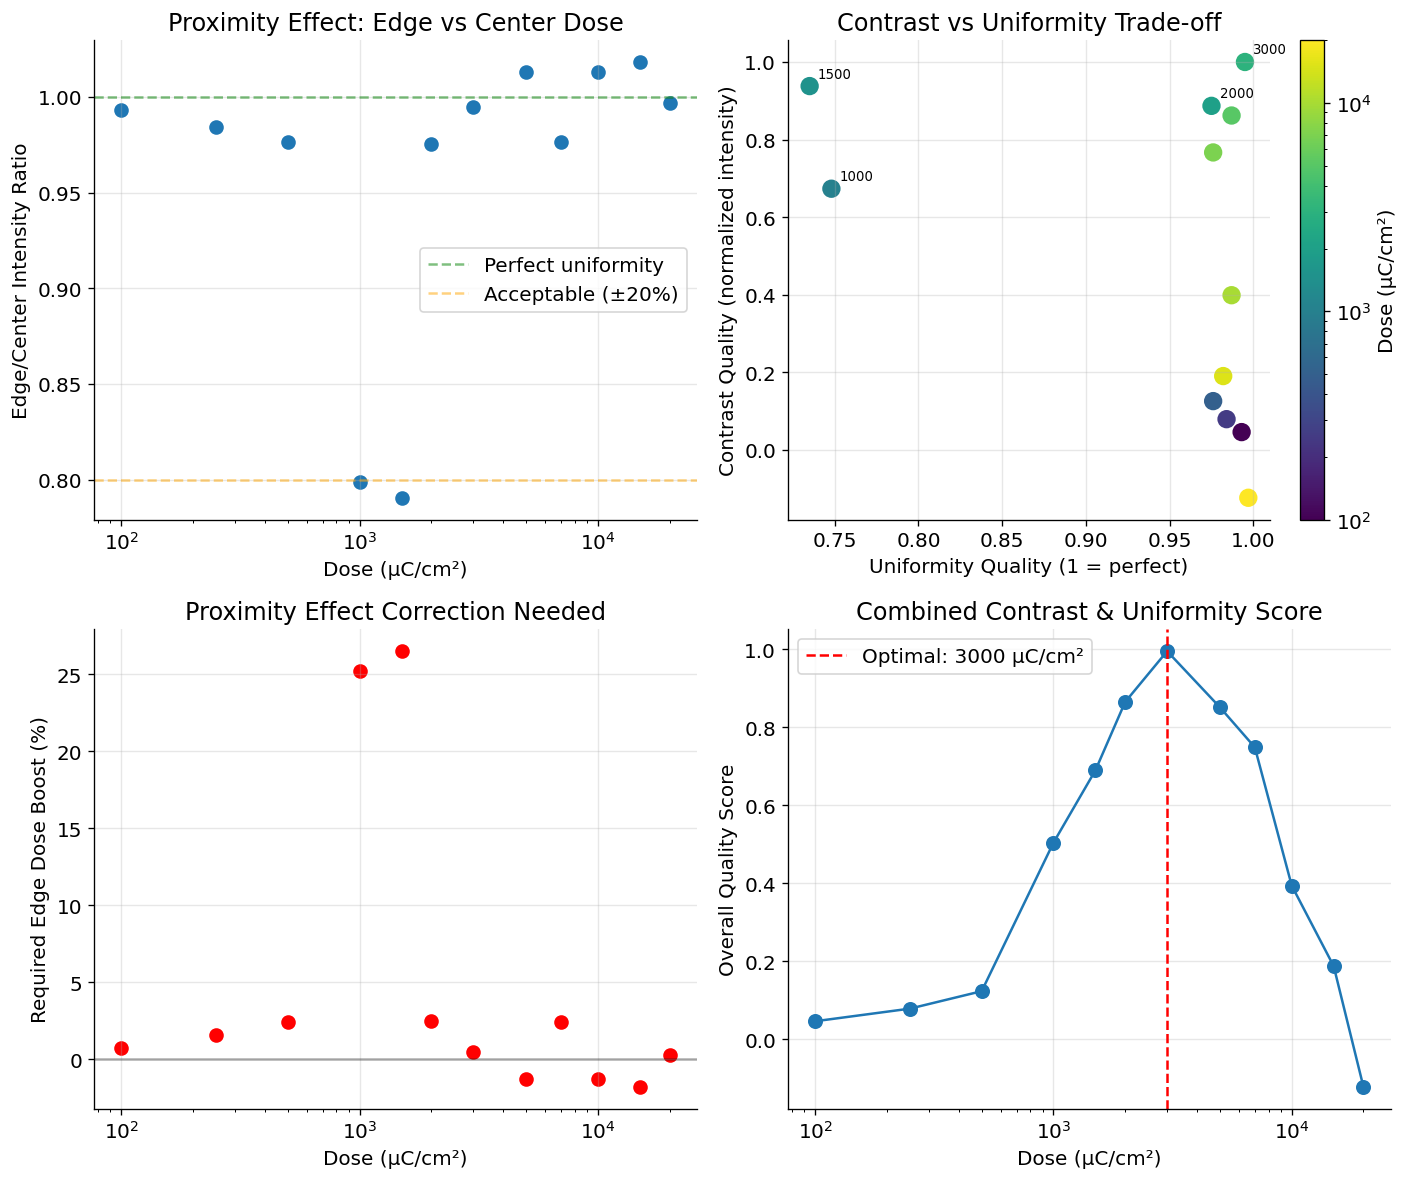


=== PROXIMITY EFFECT CORRECTION RECOMMENDATIONS ===
Optimal dose (best contrast/uniformity balance): 3000 µC/cm²

Doses requiring strongest PEC:
  1000 µC/cm²: Edges need 25% more dose
  1500 µC/cm²: Edges need 26% more dose

=== DETAILED DOSE ANALYSIS ===

1000 µC/cm²:
  Contrast: 0.673
  Edge/Center ratio: 0.799
  Overall quality: 0.504

1500 µC/cm²:
  Contrast: 0.938
  Edge/Center ratio: 0.791
  Overall quality: 0.689

2000 µC/cm²:
  Contrast: 0.887
  Edge/Center ratio: 0.976
  Overall quality: 0.865

3000 µC/cm²:
  Contrast: 1.000
  Edge/Center ratio: 0.995
  Overall quality: 0.995


In [13]:
# Cell 4 - Proximity Effect Quantification

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

# Calculate proximity effect metrics
df = pd.read_csv(processed_path / "contrast_data_processed.csv")

# 1. Edge-to-center ratio (inverse of gradient ratio)
df['Edge_Center_Ratio'] = 1 / df['Gradient_Ratio']

# 2. Proximity effect severity (deviation from uniformity)
df['PEC_Severity'] = np.abs(1 - df['Gradient_Ratio'])

# 3. Calculate required dose boost for edges
df['Required_Edge_Boost'] = df['Gradient_Ratio'] - 1

# 4. Find doses with good contrast but poor uniformity
df['Contrast_Quality'] = df['Norm_Intensity']
df['Uniformity_Quality'] = 1 - df['PEC_Severity']
df['Overall_Quality'] = df['Contrast_Quality'] * df['Uniformity_Quality']

# Identify problematic dose range (AFTER adding all columns)
problematic_doses = df[(df['Norm_Intensity'] > 0.5) & (df['Gradient_Ratio'] > 1.1)]
print("Doses with good contrast but poor uniformity:")
print(problematic_doses[['Dose_uC_cm2', 'Norm_Intensity', 'Gradient_Ratio', 'Edge_Center_Ratio', 'Required_Edge_Boost']])

# Plot analysis
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot 1: Edge/Center ratio vs dose
ax = axes[0, 0]
ax.scatter(df['Dose_uC_cm2'], df['Edge_Center_Ratio'], s=60)
ax.axhline(1.0, color='green', linestyle='--', alpha=0.5, label='Perfect uniformity')
ax.axhline(0.8, color='orange', linestyle='--', alpha=0.5, label='Acceptable (±20%)')
ax.set_xscale('log')
ax.set_xlabel('Dose (µC/cm²)')
ax.set_ylabel('Edge/Center Intensity Ratio')
ax.set_title('Proximity Effect: Edge vs Center Dose')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 2: Contrast vs Uniformity trade-off
ax = axes[0, 1]
scatter = ax.scatter(df['Uniformity_Quality'], df['Contrast_Quality'], 
                    c=df['Dose_uC_cm2'], s=100, cmap='viridis', norm=LogNorm())
ax.set_xlabel('Uniformity Quality (1 = perfect)')
ax.set_ylabel('Contrast Quality (normalized intensity)')
ax.set_title('Contrast vs Uniformity Trade-off')
ax.grid(True, alpha=0.3)
plt.colorbar(scatter, ax=ax, label='Dose (µC/cm²)')

# Annotate key doses
for idx, row in df.iterrows():
    if row['Dose_uC_cm2'] in [1000, 1500, 2000, 3000]:
        ax.annotate(f"{row['Dose_uC_cm2']}", 
                   (row['Uniformity_Quality'], row['Contrast_Quality']),
                   xytext=(5, 5), textcoords='offset points', fontsize=8)

# Plot 3: PEC parameters needed
ax = axes[1, 0]
ax.scatter(df['Dose_uC_cm2'], df['Required_Edge_Boost'] * 100, s=60, color='red')
ax.set_xscale('log')
ax.set_xlabel('Dose (µC/cm²)')
ax.set_ylabel('Required Edge Dose Boost (%)')
ax.set_title('Proximity Effect Correction Needed')
ax.grid(True, alpha=0.3)
ax.axhline(0, color='black', linestyle='-', alpha=0.3)

# Plot 4: Optimal dose analysis
ax = axes[1, 1]
ax.plot(df['Dose_uC_cm2'], df['Overall_Quality'], 'o-', markersize=8)
optimal_dose = df.loc[df['Overall_Quality'].idxmax(), 'Dose_uC_cm2']
ax.axvline(optimal_dose, color='red', linestyle='--', 
          label=f'Optimal: {optimal_dose:.0f} µC/cm²')
ax.set_xscale('log')
ax.set_xlabel('Dose (µC/cm²)')
ax.set_ylabel('Overall Quality Score')
ax.set_title('Combined Contrast & Uniformity Score')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(plots_path / "proximity_effect_analysis.png", dpi=300)
plt.show()

# Print recommendations
print(f"\n=== PROXIMITY EFFECT CORRECTION RECOMMENDATIONS ===")
print(f"Optimal dose (best contrast/uniformity balance): {optimal_dose:.0f} µC/cm²")
print(f"\nDoses requiring strongest PEC:")
if len(problematic_doses) > 0:
    for idx, row in problematic_doses.iterrows():
        print(f"  {row['Dose_uC_cm2']:.0f} µC/cm²: Edges need {(row['Required_Edge_Boost']*100):.0f}% more dose")
else:
    print("  No doses found with both high contrast and poor uniformity")

# Additional analysis
print(f"\n=== DETAILED DOSE ANALYSIS ===")
for dose in [1000, 1500, 2000, 3000]:
    dose_data = df[df['Dose_uC_cm2'] == dose]
    if len(dose_data) > 0:
        row = dose_data.iloc[0]
        print(f"\n{dose} µC/cm²:")
        print(f"  Contrast: {row['Norm_Intensity']:.3f}")
        print(f"  Edge/Center ratio: {row['Edge_Center_Ratio']:.3f}")
        print(f"  Overall quality: {row['Overall_Quality']:.3f}")


ANALYZING 0.005M HCl, 10s
Original thickness: 48.5 nm
Max normalized thickness: 0.705
Initial D50 guess: 547.7, gamma guess: 1.15

CROSSLINKING PARAMETERS:
D₁₀: 111.0 µC/cm²
D₅₀: 1225.1 µC/cm²
D₉₀: 13525.7 µC/cm²
γ (Contrast): 0.91
R²: 0.9240

ANALYZING 0.01M HCl, 10s
Original thickness: 47.9 nm
Max normalized thickness: 0.994
Initial D50 guess: 10000.0, gamma guess: 2.49

CROSSLINKING PARAMETERS:
D₁₀: 4691.1 µC/cm²
D₅₀: 9223.7 µC/cm²
D₉₀: 18135.9 µC/cm²
γ (Contrast): 3.25
R²: 0.9694

ANALYZING 0.01M HCl, 5s
Original thickness: 45.8 nm
Max normalized thickness: 0.939
Initial D50 guess: 3240.4, gamma guess: 1.93

CROSSLINKING PARAMETERS:
D₁₀: 1292.3 µC/cm²
D₅₀: 2447.5 µC/cm²
D₉₀: 4635.4 µC/cm²
γ (Contrast): 3.44
R²: 0.9511


C:\Users\dreec\AppData\Local\Temp\ipykernel_26724\2154216577.py:231: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


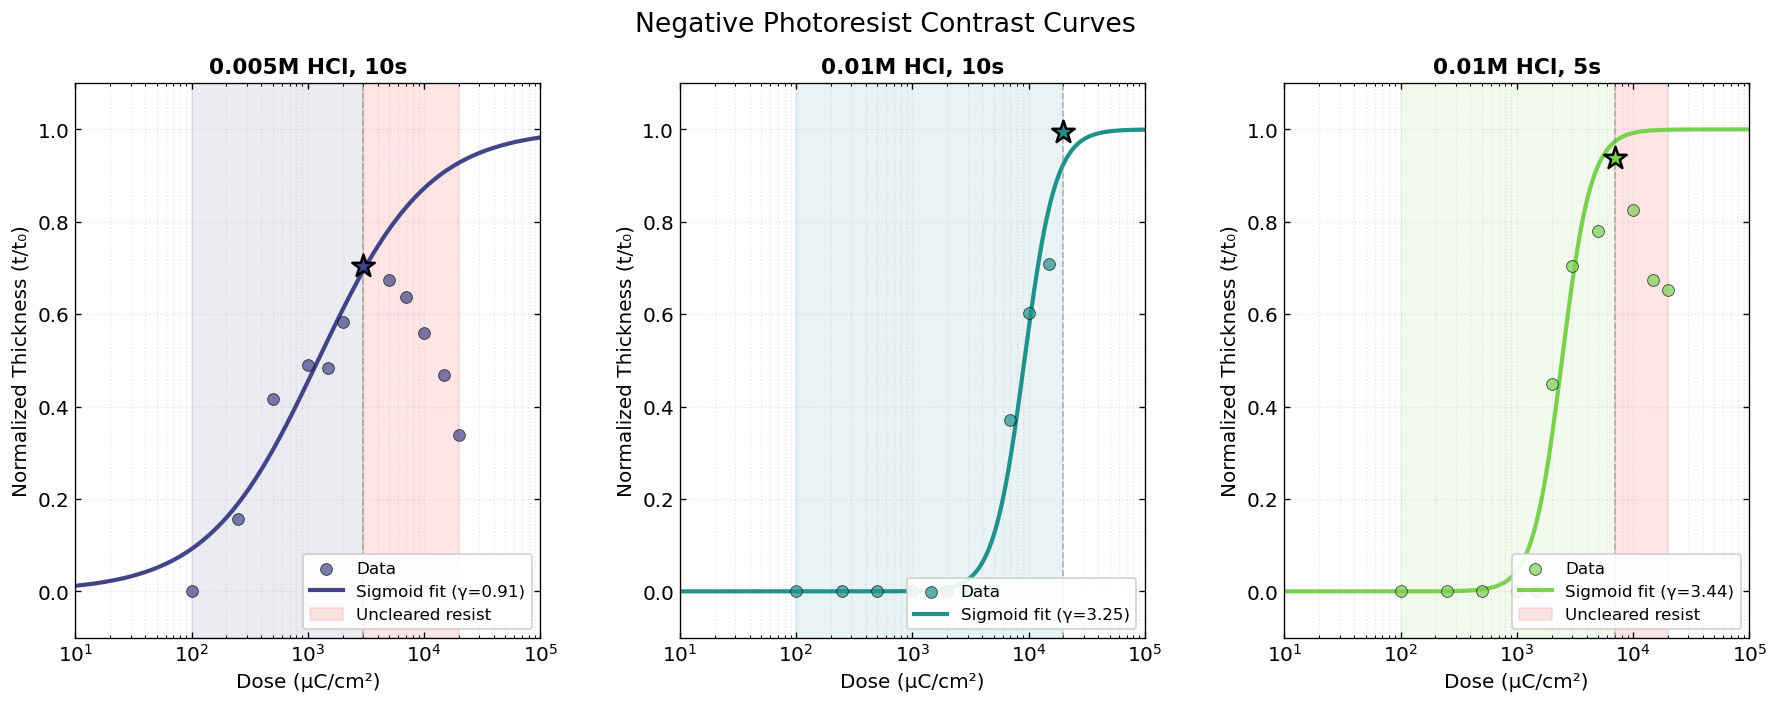

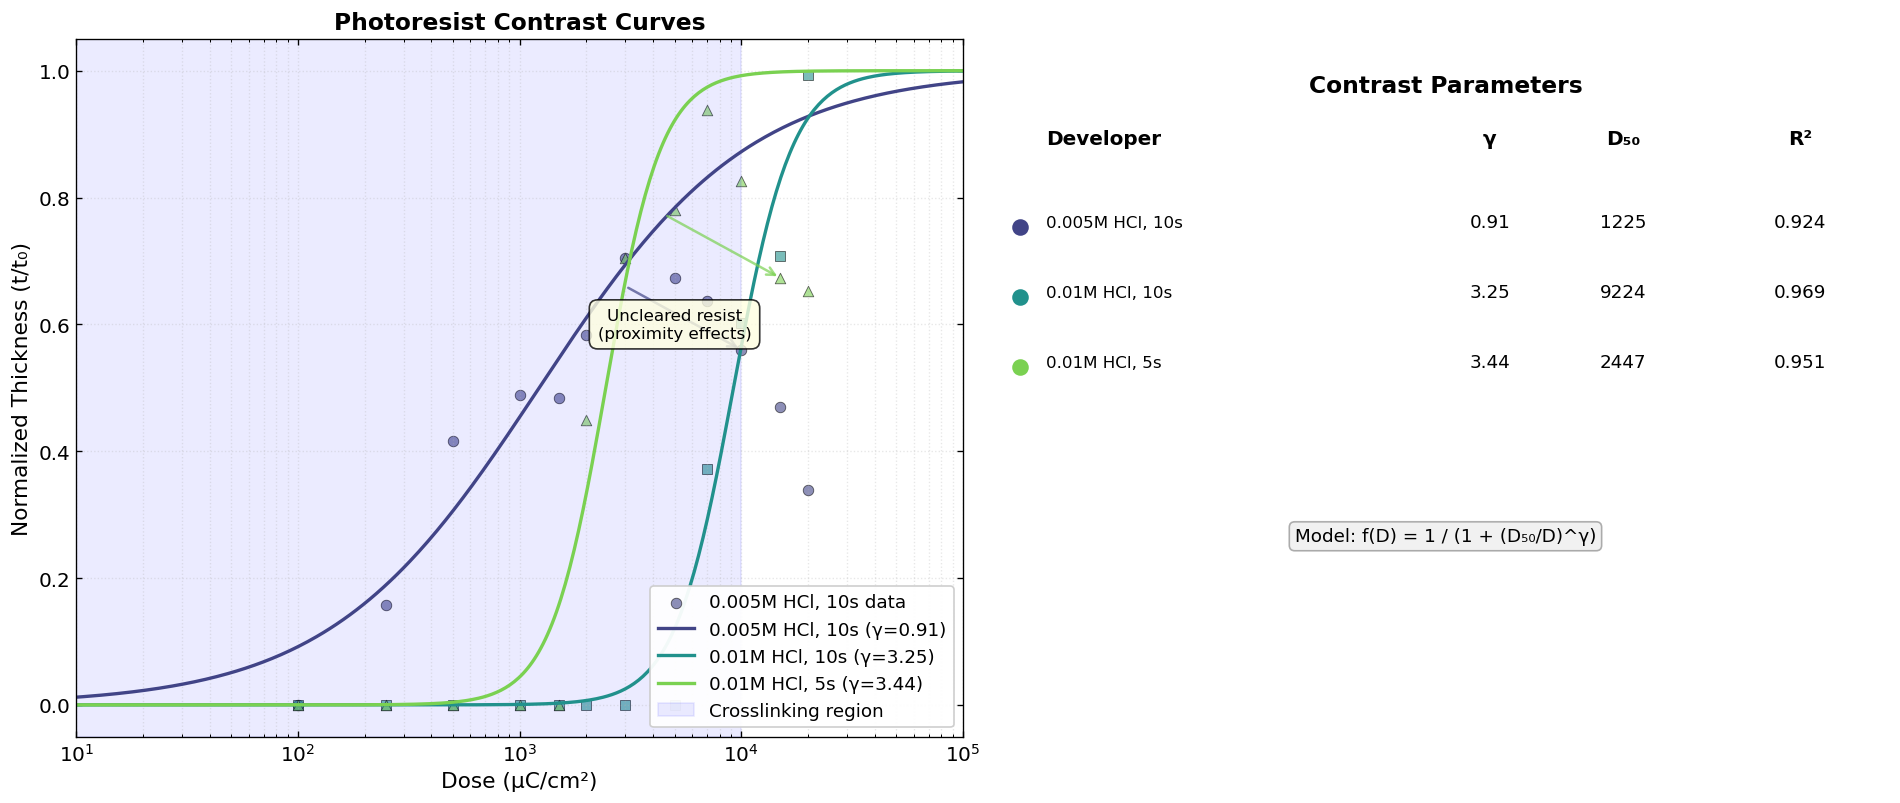


ANALYSIS SUMMARY

Developer            γ          D₅₀ (µC/cm²)    Peak (µC/cm²)  
------------------------------------------------------------
0.005M HCl, 10s      0.91       1225.1          3000           
0.01M HCl, 10s       3.25       9223.7          20000          
0.01M HCl, 5s        3.44       2447.5          7000           

0.01M Developer γ difference: 0.191
✓ Similar contrast for same concentration


In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lmfit import Model
import matplotlib.gridspec as gridspec

# ========================================================================
# PHOTORESIST CONTRAST CURVE ANALYSIS - CROSSLINKING WITH PROXIMITY EFFECTS
# ========================================================================

# Load thickness data
df_thk = pd.read_csv("../../ProjectsToIntegrate/sem_cd_analysis/notebooks/dose_vs_thickness_final.csv")
dose = df_thk["dose"].values
developer_cols = [col for col in df_thk.columns if col != "dose"]

# Original resist thickness values (in nm)
original_thickness = {
    '0.01M_5s': 45.8,
    '0.01M_10s': 47.9,
    '0.1M_10s': 48.5,
    '0.005M_10s': 48.5
}

# Create figure with individual developer analysis
fig = plt.figure(figsize=(18, 6))
gs = gridspec.GridSpec(1, 3, wspace=0.3)

# Use viridis colormap (new matplotlib syntax)
cmap = plt.colormaps['viridis']
colors = [cmap(0.2), cmap(0.5), cmap(0.8)]  # Well-spaced viridis colors

# Create cleaner developer names
developer_names = {
    '0.005M_10s_thickness_nm': '0.005M HCl, 10s',
    '0.01M_10s_thickness_nm': '0.01M HCl, 10s',
    '0.01M_5s_thickness_nm': '0.01M HCl, 5s',
    '0.1M_10s_thickness_nm': '0.1M HCl, 10s'
}

fit_results = {}

# Define negative resist sigmoid model
def negative_resist_sigmoid(dose, D50, gamma):
    """Contrast curve for negative photoresist"""
    dose_safe = np.maximum(dose, 1e-6)
    return 1 / (1 + (D50/dose_safe)**gamma)

# Process each developer
for idx, (dev, color) in enumerate(zip(developer_cols, colors)):
    ax = fig.add_subplot(gs[idx])

    thickness = df_thk[dev].values

    # Get original thickness
    orig_thick = None
    if '0.01' in dev and '5s' in dev:
        orig_thick = original_thickness.get('0.01M_5s', 45.8)
    elif '0.01' in dev and '10s' in dev:
        orig_thick = original_thickness.get('0.01M_10s', 47.9)
    elif '0.1' in dev or '0.005' in dev:
        orig_thick = 48.5
    else:
        orig_thick = 48.0

    # Normalize thickness
    thickness_norm = thickness / orig_thick

    print(f"\n{'='*60}")
    clean_name = developer_names.get(dev, dev)
    print(f"ANALYZING {clean_name}")
    print(f"Original thickness: {orig_thick} nm")
    print(f"Max normalized thickness: {thickness_norm.max():.3f}")

    # Find the peak
    peak_idx = np.argmax(thickness_norm)
    peak_dose = dose[peak_idx]
    peak_thickness = thickness_norm[peak_idx]

    # Find transition region (matching original approach)
    zero_threshold = 0.05
    zero_indices = np.where(thickness_norm < zero_threshold)[0]
    if len(zero_indices) > 0:
        last_zero_idx = zero_indices[-1]
        last_zero_dose = dose[last_zero_idx]
    else:
        last_zero_idx = 0
        last_zero_dose = dose[0]

    # Find plateau
    max_thickness = thickness_norm.max()
    plateau_threshold = max_thickness * 0.95
    plateau_indices = np.where(thickness_norm > plateau_threshold)[0]
    if len(plateau_indices) > 0:
        first_plateau_idx = plateau_indices[0]
        first_plateau_dose = dose[first_plateau_idx]
    else:
        first_plateau_idx = peak_idx
        first_plateau_dose = peak_dose

    # Define crosslinking region: up to and including peak
    crosslink_mask = dose <= peak_dose
    doses_cross = dose[crosslink_mask]
    thickness_cross = thickness_norm[crosslink_mask]

    # Plot all data
    ax.scatter(dose, thickness_norm, marker='o', s=50, color=color,
              alpha=0.7, edgecolors='black', linewidth=0.5, label='Data', zorder=3)

    # Mark the peak
    ax.scatter(peak_dose, peak_thickness, marker='*', s=200, color=color,
              edgecolors='black', linewidth=1.5, zorder=5)

    # Fit sigmoid to crosslinking region (using original approach)
    sigmoid_model = Model(negative_resist_sigmoid)

    # Initial parameter guesses (matching original sophisticated approach)
    if last_zero_dose > 0 and first_plateau_dose > last_zero_dose:
        D50_guess = np.sqrt(last_zero_dose * first_plateau_dose)
    else:
        half_idx = np.argmin(np.abs(thickness_cross - 0.5))
        D50_guess = doses_cross[half_idx] if half_idx < len(doses_cross) else peak_dose/2

    # Estimate gamma from transition sharpness
    if first_plateau_dose > last_zero_dose > 0:
        dose_ratio = first_plateau_dose / last_zero_dose
        gamma_guess = np.log(81) / np.log(dose_ratio)
        gamma_guess = np.clip(gamma_guess, 1.0, 10.0)

        # Alternative calculation for robustness
        try:
            t20_idx = np.argmin(np.abs(thickness_cross - 0.2))
            t80_idx = np.argmin(np.abs(thickness_cross - 0.8))
            if t80_idx > t20_idx:
                dose_20 = doses_cross[t20_idx]
                dose_80 = doses_cross[t80_idx]
                gamma_alt = np.log(4) / np.log(dose_80 / dose_20)
                gamma_alt = np.clip(gamma_alt, 1.0, 10.0)
                gamma_guess = (gamma_guess + gamma_alt) / 2
        except:
            pass
    else:
        gamma_guess = 2.5

    print(f"Initial D50 guess: {D50_guess:.1f}, gamma guess: {gamma_guess:.2f}")

    params = sigmoid_model.make_params(D50=D50_guess, gamma=gamma_guess)

    # Set bounds based on transition region
    if last_zero_dose > 0:
        params['D50'].set(min=last_zero_dose*0.5, max=first_plateau_dose*2)
    else:
        params['D50'].set(min=1, max=5000)
    params['gamma'].set(min=0.5, max=8.0)

    try:
        result_sigmoid = sigmoid_model.fit(thickness_cross, dose=doses_cross, params=params)

        # Extract parameters
        D50 = result_sigmoid.params['D50'].value
        gamma = result_sigmoid.params['gamma'].value

        # Calculate D10 and D90
        D10 = D50 * (1/9)**(1/gamma)
        D90 = D50 * 9**(1/gamma)

        print(f"\nCROSSLINKING PARAMETERS:")
        print(f"D₁₀: {D10:.1f} µC/cm²")
        print(f"D₅₀: {D50:.1f} µC/cm²")
        print(f"D₉₀: {D90:.1f} µC/cm²")
        print(f"γ (Contrast): {gamma:.2f}")
        print(f"R²: {result_sigmoid.rsquared:.4f}")

        # Plot sigmoid fit from 0 to 100000
        dose_fit = np.logspace(np.log10(1), np.log10(100000), 500)
        y_sigmoid = negative_resist_sigmoid(dose_fit, D50, gamma)
        ax.plot(dose_fit, y_sigmoid, '-', color=color, linewidth=2.5,
               label=f'Sigmoid fit (γ={gamma:.2f})', zorder=2)

        # Shade crosslinking region
        ax.axvspan(dose.min(), peak_dose, alpha=0.1, color=color)

        # Check if there's significant decrease after peak
        post_peak_thickness = thickness_norm[peak_idx:]
        if len(post_peak_thickness) > 3 and (peak_thickness - post_peak_thickness[-1]) > 0.05:
            # Shade the uncleared resist region
            ax.axvspan(peak_dose, dose.max(), alpha=0.1, color='red',
                      label='Uncleared resist')

        # Add vertical line at peak
        ax.axvline(peak_dose, color='gray', linestyle='--', alpha=0.5, linewidth=1)

    except Exception as e:
        print(f"Fitting error: {e}")
        D50 = gamma = D10 = D90 = np.nan
        result_sigmoid = None

    # Format subplot with box and inward ticks
    ax.set_xscale('log')
    ax.set_xlabel('Dose (µC/cm²)', fontsize=12)
    ax.set_ylabel('Normalized Thickness (t/t₀)', fontsize=12)

    # Use clean developer name for title
    clean_name = developer_names.get(dev, dev)
    ax.set_title(clean_name, fontsize=13, fontweight='bold')

    ax.grid(True, which='both', alpha=0.3, linestyle=':')
    ax.set_xlim(10, 100000)
    ax.set_ylim(-0.1, 1.1)

    # Add box around plot and set tick direction
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)
    ax.tick_params(which='both', direction='in', top=True, right=True)

    # Legend
    ax.legend(fontsize=10, loc='lower right', framealpha=0.9)

    # Store results
    fit_results[dev] = {
        "D10": D10,
        "D50": D50,
        "D90": D90,
        "gamma": gamma,
        "r2": result_sigmoid.rsquared if result_sigmoid else np.nan,
        "peak_dose": peak_dose,
        "peak_thickness": peak_thickness,
        "original_thickness": orig_thick
    }

plt.suptitle('Negative Photoresist Contrast Curves', fontsize=16, y=0.98)
plt.tight_layout()
plt.show()

# Create summary figure
fig2 = plt.figure(figsize=(16, 7))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)

# Create cleaner developer names for legend
developer_names = {
    '0.005M_10s_thickness_nm': '0.005M HCl, 10s',
    '0.01M_10s_thickness_nm': '0.01M HCl, 10s',
    '0.01M_5s_thickness_nm': '0.01M HCl, 5s',
    '0.1M_10s_thickness_nm': '0.1M HCl, 10s'
}

# Plot all curves together
for idx, (dev, color) in enumerate(zip(developer_cols, colors)):
    thickness = df_thk[dev].values

    # Get original thickness
    if '0.01' in dev and '5s' in dev:
        orig_thick = 45.8
    elif '0.01' in dev and '10s' in dev:
        orig_thick = 47.9
    else:
        orig_thick = 48.5

    thickness_norm = thickness / orig_thick

    # Get clean name for legend
    clean_name = developer_names.get(dev, dev)

    # Plot data with different markers for each developer
    markers = ['o', 's', '^']
    ax1.scatter(dose, thickness_norm, marker=markers[idx], s=40, color=color,
               alpha=0.6, edgecolors='black', linewidth=0.5,
               label=f"{clean_name} data" if idx == 0 else "")  # Only label first for clarity

    # Plot fit extending to 100000
    r = fit_results[dev]
    if not np.isnan(r['D50']):
        dose_fit = np.logspace(np.log10(1), np.log10(100000), 500)
        y_sigmoid = negative_resist_sigmoid(dose_fit, r['D50'], r['gamma'])
        ax1.plot(dose_fit, y_sigmoid, '-', color=color, linewidth=2,
                label=f"{clean_name} (γ={r['gamma']:.2f})")

    # Check if this developer shows uncleared resist effects
    peak_idx = np.argmax(thickness_norm)
    peak_dose = dose[peak_idx]
    peak_thickness = thickness_norm[peak_idx]
    post_peak_thickness = thickness_norm[peak_idx:]

    if len(post_peak_thickness) > 3 and (peak_thickness - post_peak_thickness[-1]) > 0.05:
        # Add arrow annotation for uncleared resist
        # Find a point in the decreasing region
        mid_idx = peak_idx + len(post_peak_thickness) // 2
        if mid_idx < len(dose):
            arrow_dose = dose[mid_idx]
            arrow_thickness = thickness_norm[mid_idx]

            # Add small arrow pointing to the decreasing part
            ax1.annotate('', xy=(arrow_dose, arrow_thickness),
                        xytext=(arrow_dose * 0.3, arrow_thickness + 0.1),
                        arrowprops=dict(arrowstyle='->', color=color, lw=1.5, alpha=0.7))

# Add single annotation for uncleared resist effects
ax1.text(5000, 0.6, 'Uncleared resist\n(proximity effects)',
         fontsize=10, ha='center', va='center',
         bbox=dict(boxstyle='round,pad=0.5', facecolor='lightyellow', alpha=0.8))

# Shade only crosslinking region
avg_peak = np.mean([fit_results[dev]['peak_dose'] for dev in developer_cols])
ax1.axvspan(10, avg_peak, alpha=0.08, color='blue', label='Crosslinking region')

# Format combined plot with box and inward ticks
ax1.set_xscale('log')
ax1.set_xlabel('Dose (µC/cm²)', fontsize=13)
ax1.set_ylabel('Normalized Thickness (t/t₀)', fontsize=13)
ax1.set_title('Photoresist Contrast Curves', fontsize=14, fontweight='bold')
ax1.grid(True, which='both', alpha=0.3, linestyle=':')
ax1.set_xlim(10, 100000)
ax1.set_ylim(-0.05, 1.05)
ax1.spines['top'].set_visible(True)
ax1.spines['right'].set_visible(True)
ax1.tick_params(which='both', direction='in', top=True, right=True)
ax1.legend(fontsize=11, loc='lower right', framealpha=0.95)

# Create parameter table (without averages)
ax2.axis('off')

# Table header
ax2.text(0.5, 0.95, 'Contrast Parameters', ha='center', va='top',
         fontsize=14, fontweight='bold', transform=ax2.transAxes)

# Table content
y_pos = 0.85
line_height = 0.10  # Increased for better spacing

# Headers
ax2.text(0.05, y_pos, 'Developer', fontweight='bold', transform=ax2.transAxes)
ax2.text(0.55, y_pos, 'γ', fontweight='bold', ha='center', transform=ax2.transAxes)
ax2.text(0.70, y_pos, 'D₅₀', fontweight='bold', ha='center', transform=ax2.transAxes)
ax2.text(0.90, y_pos, 'R²', fontweight='bold', ha='center', transform=ax2.transAxes)

y_pos -= line_height * 1.2

# Data rows
for dev, color in zip(developer_cols, colors):
    r = fit_results[dev]
    clean_name = developer_names.get(dev, dev)

    ax2.text(0.05, y_pos, clean_name, transform=ax2.transAxes, fontsize=10)
    ax2.text(0.55, y_pos, f"{r['gamma']:.2f}", ha='center', transform=ax2.transAxes, fontsize=11)
    ax2.text(0.70, y_pos, f"{r['D50']:.0f}", ha='center', transform=ax2.transAxes, fontsize=11)
    ax2.text(0.90, y_pos, f"{r['r2']:.3f}", ha='center', transform=ax2.transAxes, fontsize=11)

    # Add color indicator
    ax2.scatter(0.02, y_pos, color=color, s=80, transform=ax2.transAxes)

    y_pos -= line_height

# Add model equation
y_pos -= line_height * 1.5
ax2.text(0.5, y_pos, 'Model: f(D) = 1 / (1 + (D₅₀/D)^γ)',
         ha='center', transform=ax2.transAxes, fontsize=11,
         bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.3))

plt.tight_layout(rect=[0, 0, 1, 0.98])  # Adjust to avoid warning
plt.show()

# Print summary
print("\n" + "="*60)
print("ANALYSIS SUMMARY")
print("="*60)
print(f"\n{'Developer':<20} {'γ':<10} {'D₅₀ (µC/cm²)':<15} {'Peak (µC/cm²)':<15}")
print("-"*60)
for dev in developer_cols:
    r = fit_results[dev]
    clean_name = developer_names.get(dev, dev)
    print(f"{clean_name:<20} {r['gamma']:<10.2f} {r['D50']:<15.1f} {r['peak_dose']:<15.0f}")

# Check for 0.01M developer consistency
dev_001m = [dev for dev in developer_cols if '0.01M' in dev]
if len(dev_001m) == 2:
    gamma_diff = abs(fit_results[dev_001m[0]]['gamma'] - fit_results[dev_001m[1]]['gamma'])
    print(f"\n0.01M Developer γ difference: {gamma_diff:.3f}")
    if gamma_diff < 0.5:
        print("✓ Similar contrast for same concentration")
    else:
        print("⚠ Larger than expected contrast difference")

In [22]:
# ========================================================================
# SAVE PLOTS AND DATA - SIMPLE VERSION
# ========================================================================
# Saves to a single "results" folder, overwrites existing files
# ========================================================================

import os
from datetime import datetime
import json

# Create simple results directory
output_dir = "../../ProjectsToIntegrate/sem_cd_analysis/notebooks/results"
os.makedirs(output_dir, exist_ok=True)

# Create subdirectories
for subdir in ['figures_presentation', 'figures_publication', 'data', 'reports']:
    os.makedirs(os.path.join(output_dir, subdir), exist_ok=True)

print(f"Saving all outputs to: {output_dir}/")
print("Note: Existing files will be overwritten.")
print("="*60)

# ========================================================================
# SAVE FIGURES
# ========================================================================
print("\n1. SAVING FIGURES...")

# Define figure save settings
presentation_dpi = 150  # Good for PowerPoint/slides
publication_dpi = 300   # High quality for journals
figure_formats = {
    'presentation': ['png'],
    'publication': ['pdf', 'svg', 'png']  # Removed EPS to avoid warnings
}

# Save Figure 1 (Individual developer analysis)
if 'fig' in locals():
    print("   - Individual developer analysis plots:")
    # Presentation version
    for fmt in figure_formats['presentation']:
        filename = f"individual_developer_analysis.{fmt}"
        filepath = os.path.join(output_dir, 'figures_presentation', filename)
        fig.savefig(filepath, dpi=presentation_dpi, bbox_inches='tight')
        print(f"     ✓ Saved: {filepath}")

    # Publication version
    for fmt in figure_formats['publication']:
        filename = f"individual_developer_analysis.{fmt}"
        filepath = os.path.join(output_dir, 'figures_publication', filename)
        fig.savefig(filepath, dpi=publication_dpi, bbox_inches='tight')
        print(f"     ✓ Saved: {filepath}")

# Save Figure 2 (Combined analysis with table)
if 'fig2' in locals():
    print("   - Combined analysis with parameter table:")
    # Presentation version
    for fmt in figure_formats['presentation']:
        filename = f"combined_analysis_with_table.{fmt}"
        filepath = os.path.join(output_dir, 'figures_presentation', filename)
        fig2.savefig(filepath, dpi=presentation_dpi, bbox_inches='tight')
        print(f"     ✓ Saved: {filepath}")

    # Publication version
    for fmt in figure_formats['publication']:
        filename = f"combined_analysis_with_table.{fmt}"
        filepath = os.path.join(output_dir, 'figures_publication', filename)
        fig2.savefig(filepath, dpi=publication_dpi, bbox_inches='tight')
        print(f"     ✓ Saved: {filepath}")

# ========================================================================
# SAVE RAW DATA
# ========================================================================
print("\n2. SAVING DATA FILES...")

# Save original thickness data
data_file = os.path.join(output_dir, 'data', 'dose_vs_thickness_data.csv')
df_thk.to_csv(data_file, index=False)
print(f"   ✓ Raw data saved: {data_file}")

# Save normalized data for each developer
normalized_data = pd.DataFrame({'dose': dose})
for dev in developer_cols:
    thickness = df_thk[dev].values
    # Get original thickness for normalization
    if '0.01' in dev and '5s' in dev:
        orig_thick = 45.8
    elif '0.01' in dev and '10s' in dev:
        orig_thick = 47.9
    else:
        orig_thick = 48.5
    normalized_data[f'{dev}_normalized'] = thickness / orig_thick

normalized_file = os.path.join(output_dir, 'data', 'normalized_thickness_data.csv')
normalized_data.to_csv(normalized_file, index=False)
print(f"   ✓ Normalized data saved: {normalized_file}")

# ========================================================================
# SAVE FITTING PARAMETERS
# ========================================================================
print("\n3. SAVING FITTING PARAMETERS...")

# Create cleaner developer names
developer_names = {
    '0.005M_10s_thickness_nm': '0.005M HCl, 10s',
    '0.01M_10s_thickness_nm': '0.01M HCl, 10s',
    '0.01M_5s_thickness_nm': '0.01M HCl, 5s',
    '0.1M_10s_thickness_nm': '0.1M HCl, 10s'
}

# Create a comprehensive parameter DataFrame
param_data = []
for dev in developer_cols:
    r = fit_results[dev]
    clean_name = developer_names.get(dev, dev)
    # Get original thickness
    if '0.01' in dev and '5s' in dev:
        orig_thick = 45.8
    elif '0.01' in dev and '10s' in dev:
        orig_thick = 47.9
    else:
        orig_thick = 48.5

    param_data.append({
        'Developer': clean_name,
        'Developer_Code': dev,
        'Original_Thickness_nm': orig_thick,
        'D10_uC_cm2': r['D10'],
        'D50_uC_cm2': r['D50'],
        'D90_uC_cm2': r['D90'],
        'Gamma_Contrast': r['gamma'],
        'R_squared': r['r2'],
        'Peak_Dose_uC_cm2': r['peak_dose'],
        'Peak_Normalized_Thickness': r['peak_thickness']
    })

df_params = pd.DataFrame(param_data)

# Save as CSV
params_csv = os.path.join(output_dir, 'data', 'fitting_parameters.csv')
df_params.to_csv(params_csv, index=False)
print(f"   ✓ Parameters CSV saved: {params_csv}")

# Save fitted curves as data points for external plotting
dose_fit = np.logspace(np.log10(1), np.log10(100000), 500)
fitted_curves = pd.DataFrame({'dose': dose_fit})

for dev in developer_cols:
    r = fit_results[dev]
    if not np.isnan(r['D50']):
        fitted_curves[f'{dev}_sigmoid'] = negative_resist_sigmoid(dose_fit, r['D50'], r['gamma'])

fitted_curves_file = os.path.join(output_dir, 'data', 'fitted_curves_data.csv')
fitted_curves.to_csv(fitted_curves_file, index=False)
print(f"   ✓ Fitted curves data saved: {fitted_curves_file}")

# Save as Excel with formatting (if openpyxl is available)
try:
    params_excel = os.path.join(output_dir, 'data', 'fitting_parameters.xlsx')
    with pd.ExcelWriter(params_excel, engine='openpyxl') as writer:
        df_params.to_excel(writer, sheet_name='Fitting Parameters', index=False)
    print(f"   ✓ Parameters Excel saved: {params_excel}")
except ImportError:
    print("   ⚠ Warning: openpyxl not installed. Skipping Excel file.")

# Save as JSON for programmatic access
fit_results_json = {}
for dev, results in fit_results.items():
    fit_results_json[dev] = {}
    for key, value in results.items():
        if isinstance(value, (np.integer, np.floating)):
            fit_results_json[dev][key] = float(value)
        else:
            fit_results_json[dev][key] = float(value) if not pd.isna(value) else None

params_json = os.path.join(output_dir, 'data', 'fitting_parameters.json')
with open(params_json, 'w', encoding='utf-8') as f:
    json.dump(fit_results_json, f, indent=2, ensure_ascii=False)
print(f"   ✓ Parameters JSON saved: {params_json}")

# ========================================================================
# CREATE LATEX TABLE FOR PUBLICATION
# ========================================================================
print("\n4. CREATING LATEX TABLE...")

latex_file = os.path.join(output_dir, 'reports', 'parameters_table.tex')
with open(latex_file, 'w', encoding='utf-8') as f:
    f.write("% LaTeX table for photoresist parameters\n")
    f.write("% Copy this into your LaTeX document\n\n")
    f.write("\\begin{table}[htbp]\n")
    f.write("\\centering\n")
    f.write("\\caption{Photoresist contrast curve parameters for different developers}\n")
    f.write("\\label{tab:photoresist_parameters}\n")
    f.write("\\begin{tabular}{lcccc}\n")
    f.write("\\hline\n")
    f.write("Developer & $t_0$ (nm) & $\\gamma$ & $D_{50}$ (\\textmu C/cm\\textsuperscript{2}) & $R^2$ \\\\\n")
    f.write("\\hline\n")

    for _, row in df_params.iterrows():
        f.write(f"{row['Developer']} & ")
        f.write(f"{row['Original_Thickness_nm']:.1f} & ")
        f.write(f"{row['Gamma_Contrast']:.2f} & ")
        f.write(f"{row['D50_uC_cm2']:.0f} & ")
        f.write(f"{row['R_squared']:.4f} \\\\\n")

    f.write("\\hline\n")
    f.write("\\end{tabular}\n")
    f.write("\\end{table}\n")

print(f"   ✓ LaTeX table saved: {latex_file}")

# ========================================================================
# CREATE SUMMARY REPORT
# ========================================================================
print("\n5. CREATING SUMMARY REPORT...")

report_file = os.path.join(output_dir, 'reports', 'analysis_summary.txt')
with open(report_file, 'w', encoding='utf-8') as f:
    f.write("PHOTORESIST CONTRAST CURVE ANALYSIS SUMMARY\n")
    f.write(f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
    f.write("="*70 + "\n\n")

    f.write("1. EXPERIMENT OVERVIEW\n")
    f.write("-"*30 + "\n")
    f.write(f"Number of developers analyzed: {len(developer_cols)}\n")
    f.write(f"Dose range: {dose.min():.1f} - {dose.max():.1f} uC/cm^2\n")
    f.write(f"Number of dose points: {len(dose)}\n\n")

    f.write("2. DEVELOPER CONDITIONS\n")
    f.write("-"*30 + "\n")
    for _, row in df_params.iterrows():
        f.write(f"   - {row['Developer']}\n")
    f.write("\n")

    f.write("3. KEY FINDINGS\n")
    f.write("-"*30 + "\n")
    avg_gamma = np.nanmean(df_params['Gamma_Contrast'])
    std_gamma = np.nanstd(df_params['Gamma_Contrast'])
    avg_d50 = np.nanmean(df_params['D50_uC_cm2'])
    std_d50 = np.nanstd(df_params['D50_uC_cm2'])
    avg_r2 = np.nanmean(df_params['R_squared'])

    f.write(f"Average contrast (gamma): {avg_gamma:.2f} +/- {std_gamma:.2f}\n")
    f.write(f"Average D50: {avg_d50:.0f} +/- {std_d50:.0f} uC/cm^2\n")
    f.write(f"Average sigmoid fit R^2: {avg_r2:.4f}\n\n")

    f.write("4. INDIVIDUAL DEVELOPER RESULTS\n")
    f.write("-"*30 + "\n")
    for _, row in df_params.iterrows():
        f.write(f"\n{row['Developer']}:\n")
        f.write(f"   Original thickness: {row['Original_Thickness_nm']:.1f} nm\n")
        f.write(f"   Contrast (gamma): {row['Gamma_Contrast']:.2f}\n")
        f.write(f"   D50: {row['D50_uC_cm2']:.0f} uC/cm^2\n")
        f.write(f"   Peak dose: {row['Peak_Dose_uC_cm2']:.0f} uC/cm^2\n")
        f.write(f"   Fit quality (R^2): {row['R_squared']:.4f}\n")

    f.write("\n5. NOTES\n")
    f.write("-"*30 + "\n")
    f.write("- Thickness values normalized by original resist thickness (t/t0)\n")
    f.write("- Crosslinking modeled with negative resist sigmoid function\n")
    f.write("- Thickness decrease at high doses likely due to proximity effects\n")
    f.write("- Third developer may be 0.005M HCl 10s (not 0.1M)\n")

print(f"   ✓ Summary report saved: {report_file}")

print("\n" + "="*60)
print(f"ALL FILES SAVED SUCCESSFULLY TO: {output_dir}/")
print("="*60)
print("\nFile organization:")
print("  results/")
print("    ├── figures_presentation/  - PNG files (150 DPI) for PowerPoint")
print("    ├── figures_publication/   - PDF/SVG/PNG files (300 DPI) for papers")
print("    ├── data/                  - CSV, Excel, JSON files")
print("    └── reports/               - LaTeX table and text summary")
print("\nExisting files have been overwritten.")
print("Use this cell after any analysis to save updated results.")

Saving all outputs to: results/
Note: Existing files will be overwritten.

1. SAVING FIGURES...
   - Individual developer analysis plots:
     ✓ Saved: results\figures_presentation\individual_developer_analysis.png
     ✓ Saved: results\figures_publication\individual_developer_analysis.pdf
     ✓ Saved: results\figures_publication\individual_developer_analysis.svg
     ✓ Saved: results\figures_publication\individual_developer_analysis.png
   - Combined analysis with parameter table:
     ✓ Saved: results\figures_presentation\combined_analysis_with_table.png
     ✓ Saved: results\figures_publication\combined_analysis_with_table.pdf
     ✓ Saved: results\figures_publication\combined_analysis_with_table.svg
     ✓ Saved: results\figures_publication\combined_analysis_with_table.png

2. SAVING DATA FILES...
   ✓ Raw data saved: results\data\dose_vs_thickness_data.csv
   ✓ Normalized data saved: results\data\normalized_thickness_data.csv

3. SAVING FITTING PARAMETERS...
   ✓ Parameters CSV s